# Introduction

This is an example notebook that uses the (unweighted) HXE to classify faux supernovae using their durations and luminosities. 

In [54]:
# Import statements
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import sys
sys.path.insert(0, './hxetda/')
import hxetda
import importlib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_recall_fscore_support


First, we make our taxonomy graph. This is *not just* a visual aid -- the graph structure is explicitely passed into our objective function! The top node is the parent class to which all objects belong. In our case, every object is a "supernova". The leaf nodes are the most specialized classes, but the code will return a probability of belonging to any class.

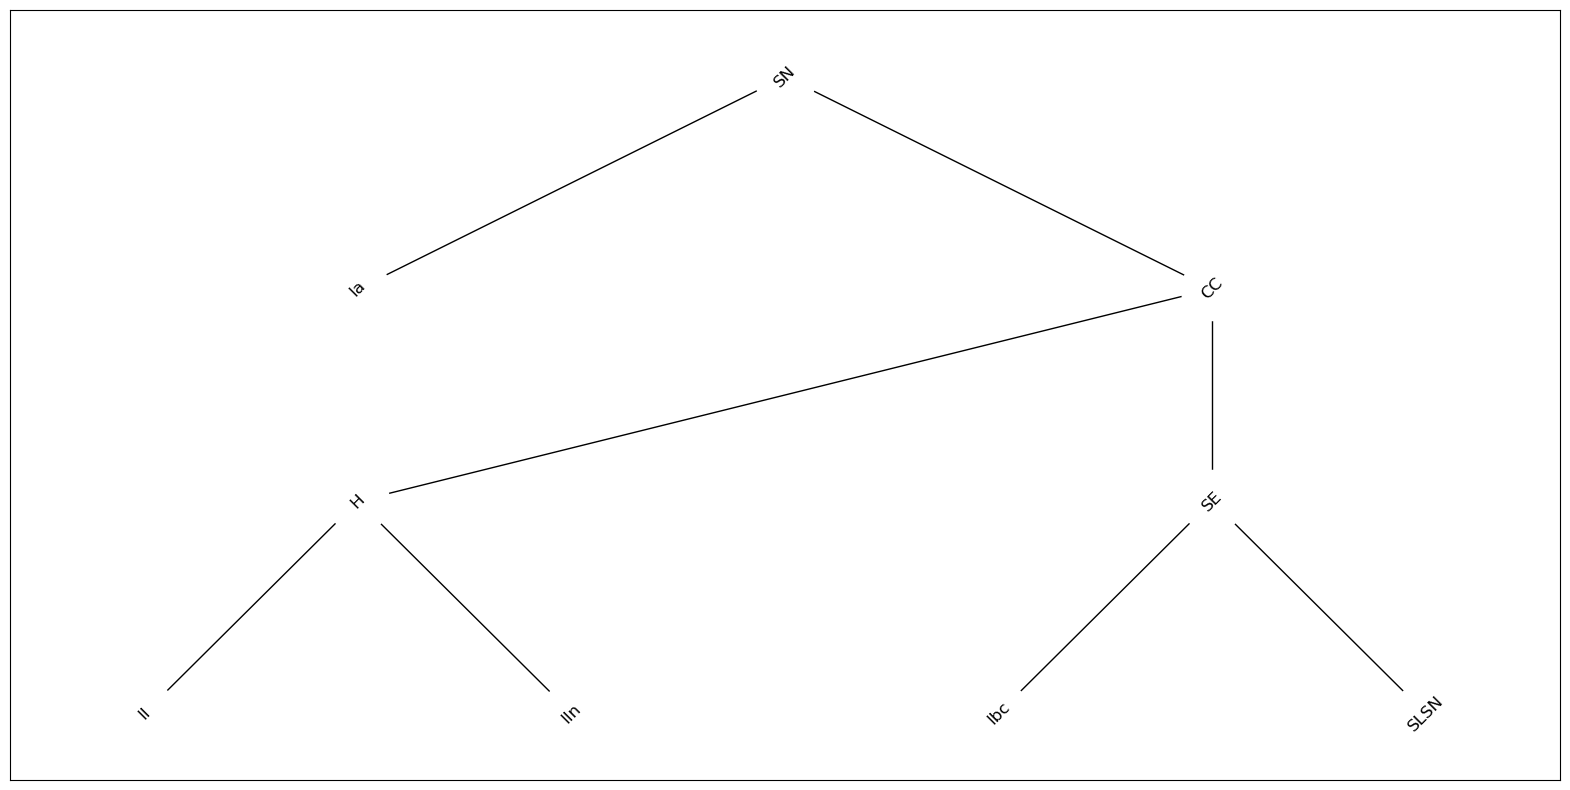

In [63]:
# Make a graph
# Note here -- "SE" = Stripped-envelope (as opposed to hydrogen-rich)
vertices = ['SN', 'Ia', 'CC', 'H', 'SE', 'II', 'Ibc', 'IIn', 'SLSN']

G=nx.DiGraph()
G.add_edge('SN','Ia')
G.add_edge('SN','CC')
G.add_edge('CC','H')
G.add_edge('CC','SE')
G.add_edge('H','II')
G.add_edge('H','IIn')
G.add_edge('SE','Ibc')
G.add_edge('SE','SLSN')

fig = plt.figure(1, figsize=(20, 10))

importlib.reload(hxetda) # You don't need to do this, but it is for debugging
pos = hxetda.hierarchy_pos(G, 'SN') #This function just makes a pretty plot
nx.draw_networkx(G, pos=pos, nodelist=vertices, node_color='white', with_labels=False, node_size=2000, arrows=False)
text = nx.draw_networkx_labels(G, pos)
for _, t in text.items():
    t.set_rotation(45) 

plt.show()

In [64]:
# Some pre-processing for the graph -- this just makes some helpful functions our objective function will want
importlib.reload(hxetda)
paths, pathlengths, mask_list, y_dict = hxetda.calc_path_and_mask(G, vertices, 'SN')

We're going to make a fake SN population, consisting of five classes: Ia, II, IIn, Ibc and SLSNe (the leaf nodes of the above graph). They will all be drawn form Gaussian distributions.

(500, 2)


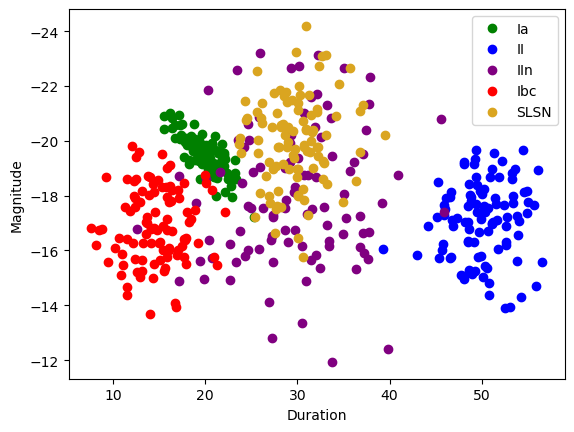

In [65]:
# Make a fake population, using peak luminosity and duration to classify
# Note -- this is just a toy example! Please don't take values literally!!
ia_features = multivariate_normal.rvs(mean=[20,-19.5], cov=[[3,1],[1,0.5]], size=100)
ii_features = multivariate_normal.rvs(mean=[50,-17], cov=[10,2], size=100)
iin_features = multivariate_normal.rvs(mean=[30,-18], cov=[50,5], size=100)
ibc_features = multivariate_normal.rvs(mean=[15,-17], cov=[10,2], size=100)
slsn_features = multivariate_normal.rvs(mean=[30,-20], cov=[10,2], size=100)

plt.plot(ia_features[:,0],ia_features[:,1],'o',color='green',label='Ia')
plt.plot(ii_features[:,0],ii_features[:,1],'o',color='blue',label='II')
plt.plot(iin_features[:,0],iin_features[:,1],'o',color='purple',label='IIn')
plt.plot(ibc_features[:,0],ibc_features[:,1],'o',color='red',label='Ibc')
plt.plot(slsn_features[:,0],slsn_features[:,1],'o',color='goldenrod',label='SLSN')

plt.xlabel('Duration')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()
plt.legend()

# I am also going to go ahead and make our training/test set by adding labels to each set of features
labels = np.repeat(['Ia', 'II','IIn','Ibc','SLSN'], 100)
labels_new = [y_dict[x] for x in labels]
all_features = np.vstack((ia_features, ii_features, iin_features, ibc_features, slsn_features))
print(np.shape(all_features))
X_train, X_test, y_train, y_test, train_labels, test_labels = train_test_split(all_features, labels_new, labels, test_size=0.33, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

Great! Now we will train a multi-layer perceptron to classify these supernovae, using the graph we defined above. Note that our supernovae belong to the leaf nodes, but they could have belonged to any of the nodes and we would still be able to train the network.

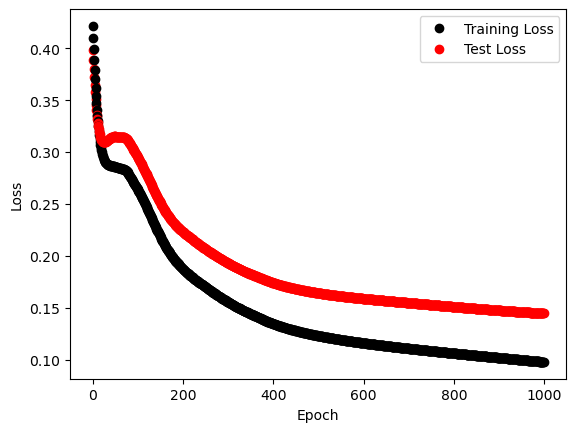

In [79]:
# Train!

model = hxetda.Feedforward(np.shape(X_test[0])[0],15, len(vertices))
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
model.train()
epoch = 1000
n_batches = 128
loss=torch.tensor(0)
for epoch in range(epoch):
	for i in range(int(len(X_train)/n_batches)+1):
		# Local batches and labels
		local_X, local_y = X_train[i*n_batches:(i+1)*n_batches,], y_train[i*n_batches:(i+1)*n_batches,]
		optimizer.zero_grad()
		# Forward pass
		y_pred = model(local_X)
		# Compute Loss
		loss = hxetda.custom_hier_loss(y_pred.to(torch.float),local_y.to(torch.float), mask_list, pathlengths)
		# Backward pass
		loss.backward()
		optimizer.step()
	ypred2 = model(X_test)
	loss2 = hxetda.custom_hier_loss(ypred2.to(torch.float),y_test.to(torch.float), mask_list, pathlengths);
	if epoch ==0:
		plt.plot(epoch,np.mean(loss.detach().numpy()),'ko', label = 'Training Loss');
		plt.plot(epoch,loss2.detach().numpy(),'ro', label = 'Test Loss');

	else:
		plt.plot(epoch,np.mean(loss.detach().numpy()),'ko');
		plt.plot(epoch,loss2.detach().numpy(),'ro');

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Now that we have trained out classifier, we will evaluate its performance on the 5-way classification task.

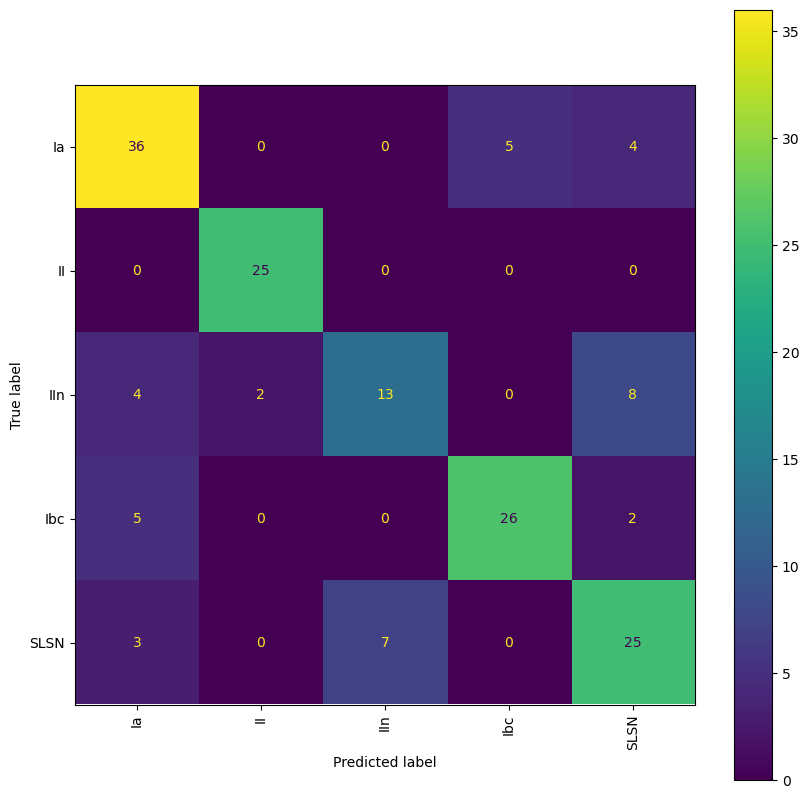

In [82]:
# First, get the predictions. You'll notice that the output of the model is *not* very human readable.
# It is connected to the adjacancy matrix of the graph, but our get_prob function lets us easily calculate
# any class probabiltiy

model.eval()
y_pred = model(X_test)

# Get my leaves...Again, this could be any set of nodes!
importlib.reload(hxetda)
leaves = np.asarray(['Ia', 'II','IIn','Ibc','SLSN'], dtype=str)
vertices = np.asarray(vertices, dtype=str)
probs_list = np.zeros((len(y_pred), len(leaves)))

for i,leaf in enumerate(leaves):
    probs_list[:,i] = hxetda.get_prob(y_pred,leaf, paths, vertices, mask_list).detach().numpy()

my_predicted_types = leaves[np.argmax(probs_list,axis=1)]

fiveleaf_labels_test = np.copy(test_labels)

gind = np.where(np.in1d(fiveleaf_labels_test,leaves))[0]
cm = confusion_matrix(fiveleaf_labels_test[gind], my_predicted_types[gind], labels=leaves)
disp = ConfusionMatrixDisplay(cm, display_labels=leaves)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation='vertical', ax=ax)


<class 'numpy.ndarray'>


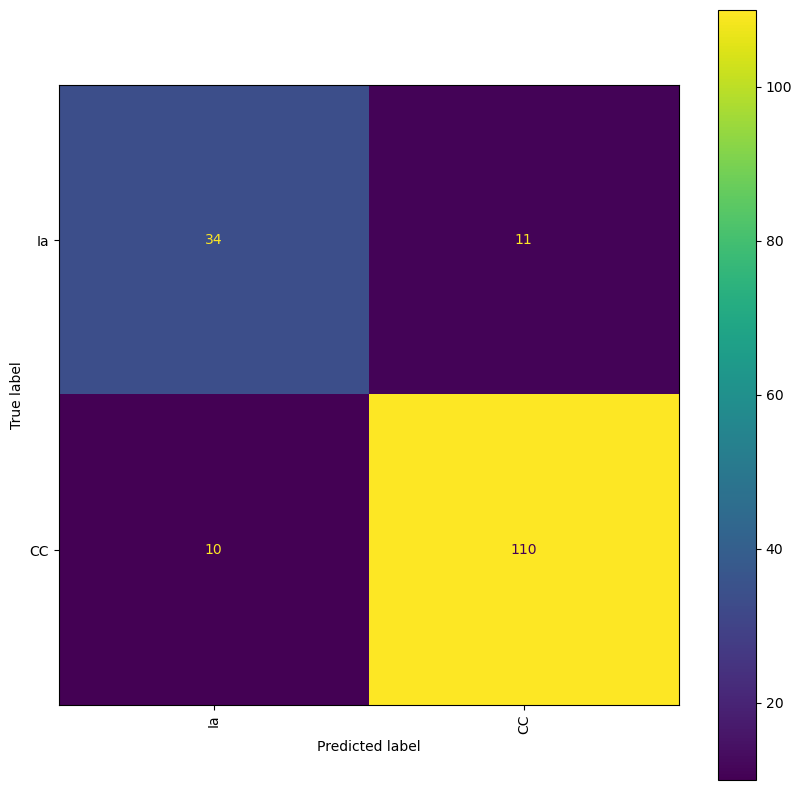

In [89]:
# We can easily do the same for Ia vs CC classification as well:
leaves = np.asarray(['Ia', 'CC'], dtype=str)
vertices = np.asarray(vertices, dtype=str)
probs_list = np.zeros((len(y_pred), len(leaves)))

for i,leaf in enumerate(leaves):
    probs_list[:,i] = hxetda.get_prob(y_pred,leaf, paths, vertices, mask_list).detach().numpy()

my_predicted_types = leaves[np.argmax(probs_list,axis=1)]

twoleaf_labels_test = np.copy(test_labels)
print(type(twoleaf_labels_test))
gind = np.where(twoleaf_labels_test != 'Ia')
twoleaf_labels_test[gind] = 'CC'


gind = np.where(np.in1d(twoleaf_labels_test,leaves))[0]
cm = confusion_matrix(twoleaf_labels_test[gind], my_predicted_types[gind], labels=leaves)
disp = ConfusionMatrixDisplay(cm, display_labels=leaves)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation='vertical', ax=ax)